In [1]:
!pip install pywavelets

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt

import os

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [8]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O dataset.zip

zsh:1: command not found: wget


In [3]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [9]:
data_dir = "UCI HAR Dataset"

def read_data(split):
    global data_dir
    path = os.path.join(data_dir, split, "Inertial Signals")
    files = os.listdir(path)
    files = [
        f'total_acc_z_{split}.txt', f'total_acc_y_{split}.txt', f'total_acc_x_{split}.txt', 
        f'body_acc_z_{split}.txt', f'body_acc_y_{split}.txt',  f'body_acc_x_{split}.txt', 
        f'body_gyro_z_{split}.txt', f'body_gyro_y_{split}.txt', f'body_gyro_x_{split}.txt', 
    ]
    
    X = torch.zeros((7352 if split == "train" else 2947, 9, 128))
    
    for i, file in enumerate(files):
        j = 0 
        with open(os.path.join(path, file), "r") as f:
            content = f.readlines()
            content = list(map(lambda x: x.split(" "), content))

            for line in content:
              X[j, i] = torch.Tensor([float(x) for x in line if x != ""])
              j += 1
    
    with open(os.path.join(data_dir, split, f"y_{split}.txt"), "r") as f:
        content = f.readlines()
        y = np.array(content).astype(float)
                
    return X, torch.tensor(y)

In [10]:
X_train, y_train = read_data(split="train")
val_size = int(0.95 * X_train.size(0))

X_valid, y_valid = X_train[val_size:], y_train[val_size:]
X_train, y_train = X_train[:val_size], y_train[:val_size]
X_test, y_test = read_data(split="test")

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

(torch.Size([6984, 9, 128]),
 torch.Size([6984]),
 torch.Size([2947, 9, 128]),
 torch.Size([2947]),
 torch.Size([368, 9, 128]),
 torch.Size([368]))

In [11]:
def cwt(signal):
    wavelet='cmor0.8-1.5'
    dt = 1 / 2048
    fa = np.arange(1, 129)
    a = pywt.central_frequency(wavelet) / (dt * fa)
    coeff, freqs = pywt.cwt(signal, a, wavelet, dt)
    
    return coeff

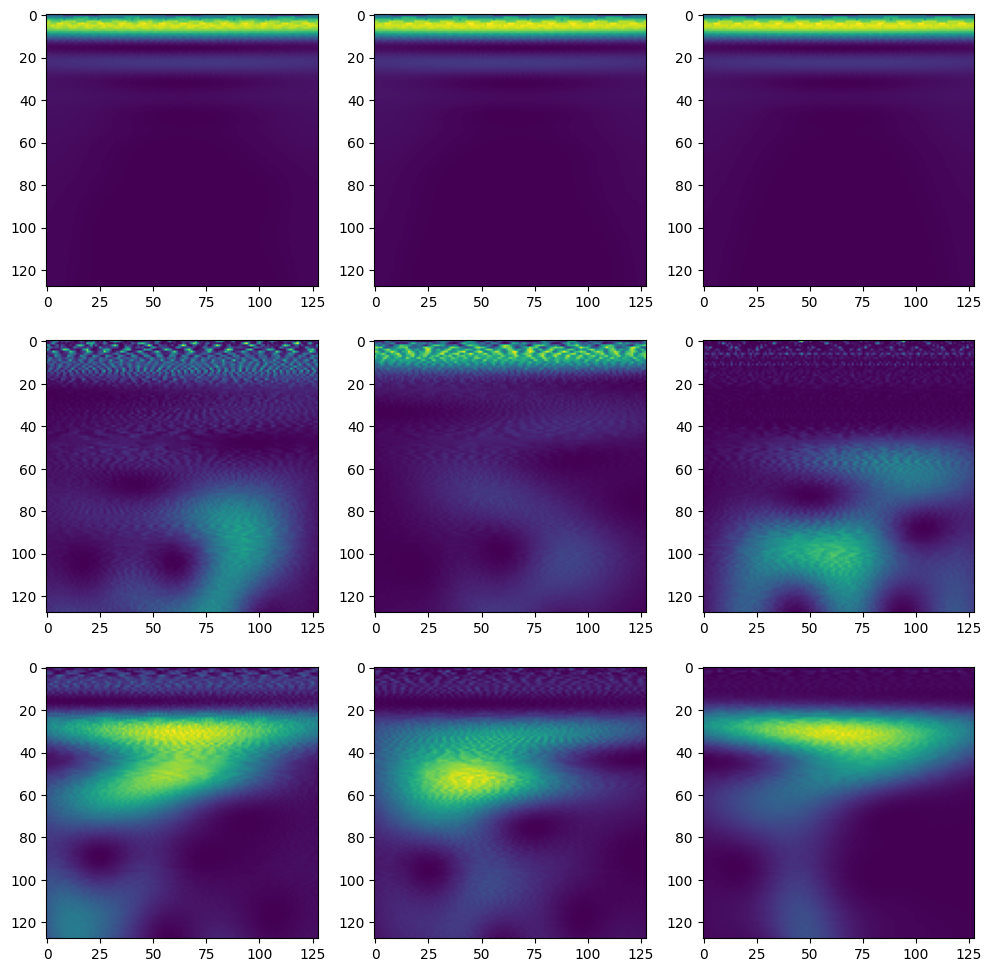

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, signal in zip(axes.flat, X_train[5]):
    cwt_signal = abs(cwt(signal.numpy())) ** 2
    ax.imshow(cwt_signal)

In [13]:
def process_data(data):
    data_transformed = torch.zeros((*data.shape, 128))
    for i, line in enumerate(data):
        for j, signal in enumerate(line):
          data_transformed[i][j] = torch.Tensor(cwt(signal.numpy()))
        if i % 250 == 0:
            print(f"Processed {(i + 1):4d} / {len(data)}")
    return data_transformed

In [14]:
X_train_transformed = process_data(X_train)
X_valid_transformed = process_data(X_valid)
X_test_transformed = process_data(X_test)

Processed    1 / 6984
Processed  251 / 6984
Processed  501 / 6984
Processed  751 / 6984
Processed 1001 / 6984
Processed 1251 / 6984
Processed 1501 / 6984
Processed 1751 / 6984
Processed 2001 / 6984
Processed 2251 / 6984
Processed 2501 / 6984
Processed 2751 / 6984
Processed 3001 / 6984
Processed 3251 / 6984
Processed 3501 / 6984
Processed 3751 / 6984
Processed 4001 / 6984
Processed 4251 / 6984
Processed 4501 / 6984
Processed 4751 / 6984
Processed 5001 / 6984
Processed 5251 / 6984
Processed 5501 / 6984
Processed 5751 / 6984
Processed 6001 / 6984
Processed 6251 / 6984
Processed 6501 / 6984
Processed 6751 / 6984
Processed    1 / 368
Processed  251 / 368
Processed    1 / 2947
Processed  251 / 2947
Processed  501 / 2947
Processed  751 / 2947
Processed 1001 / 2947
Processed 1251 / 2947
Processed 1501 / 2947
Processed 1751 / 2947
Processed 2001 / 2947
Processed 2251 / 2947
Processed 2501 / 2947
Processed 2751 / 2947


In [15]:
y_train -= 1
y_test -= 1
y_valid -= 1

y_train = torch.Tensor(y_train).long()
y_valid = torch.Tensor(y_valid).long()
y_test = torch.Tensor(y_test).long()

In [16]:
train_dataset = torch.utils.data.TensorDataset(X_train_transformed, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid_transformed, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test_transformed, y_test)

In [17]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6984, 368, 2947)

In [18]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(valid_dataset, "valid_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

In [19]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

len(train_dataloader), len(train_dataloader.dataset), len(valid_dataloader), len(valid_dataloader.dataset), len(test_dataloader), len(test_dataloader.dataset)

(55, 6984, 3, 368, 24, 2947)

In [2]:
class CNN(nn.Module):
  def __init__(self, filters, hidden_units, dropout=0.2):
    super(CNN, self).__init__()
    self.dropout = dropout
    self.conv1 = nn.Conv2d(in_channels=9, out_channels=filters, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(num_features=filters)
    self.conv2 = nn.Conv2d(in_channels=filters, out_channels=32, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=hidden_units)
    self.fc2 = nn.Linear(in_features=hidden_units, out_features=6)

  def forward(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, 5)
    x = self.bn1(F.relu(x))

    x = self.conv2(x)
    x = F.max_pool2d(x, 5)
    x = self.bn2(F.relu(x))

    x = F.dropout(x, 0.1)

    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)  

In [51]:
def validation(model, device, dataloader, return_output=False):
  model.eval()
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  all_output = torch.zeros((len(dataloader), batch_size))
  all_output = list()
  with torch.inference_mode():
    avg_loss = 0
    avg_acc = 0
    for i, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc="validation"):
      X, y = X.to(device), y.to(device)
      output = model(X)
      for val in torch.argmax(output, dim=1).ravel().numpy():
        all_output.append(val)
      loss = criterion(output, y)
      avg_loss += loss.item()
      avg_acc += (torch.argmax(output, dim=1) == y).float().mean().item()

    avg_acc /= len(dataloader) 
    avg_loss /= len(dataloader)

  model.train()

  if return_output:
    return all_output, avg_acc, avg_loss
  
  return avg_acc, avg_loss

def train_loop(model, dataloader, valid_dataloader, device, epochs, learning_rate=1e-4, momentum=0.9, wd=0, use_scheduler=False):
  model.train()
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd, betas=(momentum, 0.999))
  if use_scheduler:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
  train_losses = []
  val_losses = []
  for epoch in tqdm(range(epochs), desc="training"): 
    curr_loss = 0
    for i, (X, y) in enumerate(dataloader):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      output = model(X)
      loss = criterion(output, y)
      curr_loss += loss.item()
      loss.backward()
      optimizer.step()
      if i % 50 == 0:
        print(f"[Epoch {(epoch+1):3d}/{epochs:3d}][{i:3d}/{len(dataloader):3d}] train_loss: {loss.item():.6f}")
    if use_scheduler:
      scheduler.step()
    curr_loss /= len(dataloader)
    val_acc, val_loss = validation(model, device, valid_dataloader)
    print(f"[Epoch {(epoch+1):3d}/{epochs:3d}] train_loss: {curr_loss:.6f}, val_loss: {val_loss:.6f}, val_acc: {val_acc:2.6f}")
    train_losses.append(curr_loss)
    val_losses.append(val_loss)
  
  return train_losses, val_losses

In [22]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN(filters=64, hidden_units=128, dropout=0.5).to(device)

train_losses, val_losses = train_loop(model=cnn, dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                                      device=device, epochs=10, learning_rate=7e-5, momentum=0.85, wd=0.09, use_scheduler=False)

training:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch   1/ 10][  0/ 55] train_loss: 1.815314
[Epoch   1/ 10][ 50/ 55] train_loss: 0.712829


training:  10%|█         | 1/10 [00:43<06:32, 43.59s/it]

[Epoch   1/ 10] train_loss: 1.085856, val_loss: 0.706787, val_acc: 0.855283
[Epoch   2/ 10][  0/ 55] train_loss: 0.650684
[Epoch   2/ 10][ 50/ 55] train_loss: 0.378247


training:  20%|██        | 2/10 [01:29<05:58, 44.80s/it]

[Epoch   2/ 10] train_loss: 0.487346, val_loss: 0.374833, val_acc: 0.927083
[Epoch   3/ 10][  0/ 55] train_loss: 0.358030
[Epoch   3/ 10][ 50/ 55] train_loss: 0.265119


training:  30%|███       | 3/10 [02:13<05:12, 44.69s/it]

[Epoch   3/ 10] train_loss: 0.313482, val_loss: 0.288147, val_acc: 0.940104
[Epoch   4/ 10][  0/ 55] train_loss: 0.295416
[Epoch   4/ 10][ 50/ 55] train_loss: 0.220670


training:  40%|████      | 4/10 [02:57<04:25, 44.30s/it]

[Epoch   4/ 10] train_loss: 0.247769, val_loss: 0.247618, val_acc: 0.931920
[Epoch   5/ 10][  0/ 55] train_loss: 0.252381
[Epoch   5/ 10][ 50/ 55] train_loss: 0.195329


training:  50%|█████     | 5/10 [03:41<03:40, 44.15s/it]

[Epoch   5/ 10] train_loss: 0.217964, val_loss: 0.219511, val_acc: 0.934896
[Epoch   6/ 10][  0/ 55] train_loss: 0.162625
[Epoch   6/ 10][ 50/ 55] train_loss: 0.213210


training:  60%|██████    | 6/10 [04:24<02:54, 43.75s/it]

[Epoch   6/ 10] train_loss: 0.201354, val_loss: 0.224699, val_acc: 0.929688
[Epoch   7/ 10][  0/ 55] train_loss: 0.170704
[Epoch   7/ 10][ 50/ 55] train_loss: 0.194352


training:  70%|███████   | 7/10 [05:07<02:10, 43.41s/it]

[Epoch   7/ 10] train_loss: 0.188951, val_loss: 0.197257, val_acc: 0.942708
[Epoch   8/ 10][  0/ 55] train_loss: 0.195762
[Epoch   8/ 10][ 50/ 55] train_loss: 0.231958


training:  80%|████████  | 8/10 [05:49<01:26, 43.03s/it]

[Epoch   8/ 10] train_loss: 0.183631, val_loss: 0.192106, val_acc: 0.934896
[Epoch   9/ 10][  0/ 55] train_loss: 0.204176
[Epoch   9/ 10][ 50/ 55] train_loss: 0.166433


training:  90%|█████████ | 9/10 [06:33<00:43, 43.44s/it]

[Epoch   9/ 10] train_loss: 0.177937, val_loss: 0.188207, val_acc: 0.950521
[Epoch  10/ 10][  0/ 55] train_loss: 0.183740
[Epoch  10/ 10][ 50/ 55] train_loss: 0.188597


training: 100%|██████████| 10/10 [07:16<00:00, 43.64s/it]

[Epoch  10/ 10] train_loss: 0.174294, val_loss: 0.180130, val_acc: 0.947917


validation: 100%|██████████| 24/24 [00:08<00:00,  2.91it/s]


(0.9228515625, 0.2600378297890226)

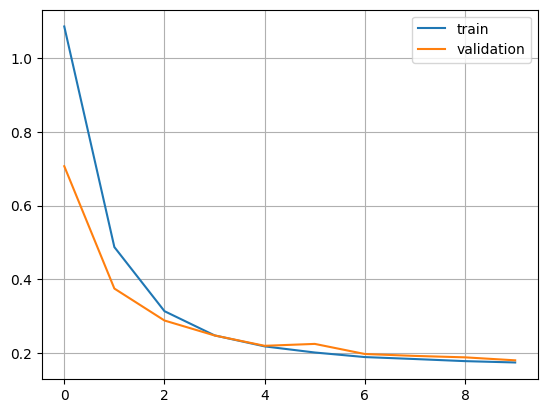

In [23]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.grid()

validation(cnn, device, test_dataloader)

In [57]:
output, _, _ = validation(cnn, device, test_dataloader, return_output=True)

target = list()

for (_, y) in test_dataloader:
    for val in y:
        target.append(val)


validation: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s]


<Axes: >

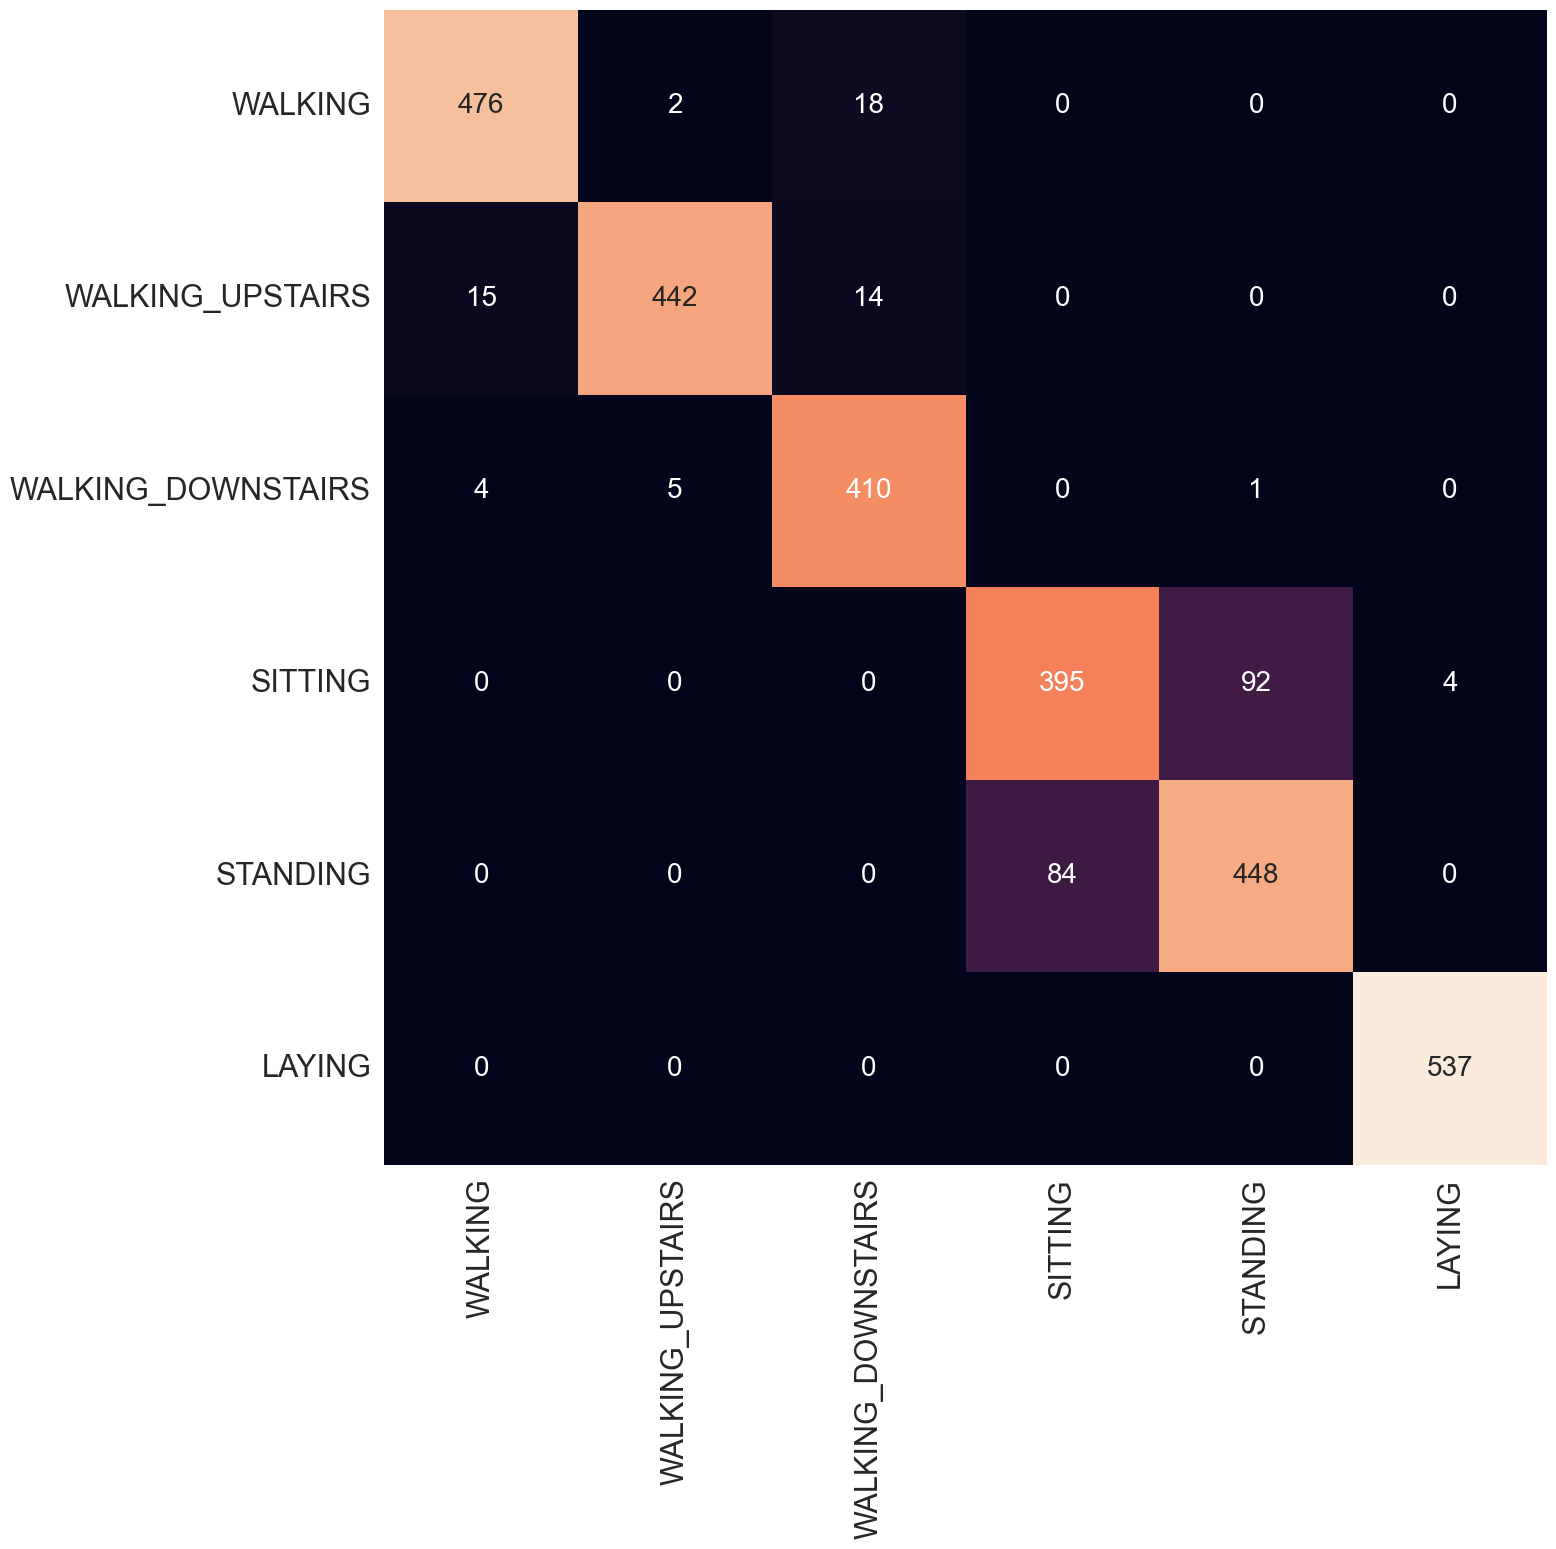

In [75]:
c_labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

cm = confusion_matrix(target, output)
sns.set(font_scale = 2)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, annot_kws={"fontsize":20},  fmt=".3g", xticklabels=c_labels, yticklabels=c_labels, cbar=False)



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN(filters=64, hidden_units=128, dropout=0.5).to(device)